<img src="https://www.nlplanet.org/images/NLP_tasks.png" width="800">


# Classification
## Example: IMDB Genre Classification
<img src="https://upload.wikimedia.org/wikipedia/commons/6/69/IMDB_Logo_2016.svg" width="200">

# Install Package

In [0]:
!pip install sentence_transformers


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
import pickle

from keras import layers
from keras.models import Sequential
from keras.backend import clear_session
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import torch 

from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Input Data

In [0]:
train_path = "/dbfs/FileStore/tables/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', engine='python', names=['ID', 'Title','Genre','Description'])
print(train_data.info())
print()
print("Number of Distinct Genres:", train_data['Genre'].nunique())
print()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   Title        54214 non-null  object
 2   Genre        54214 non-null  object
 3   Description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB
None

Number of Distinct Genres: 27



,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [0]:
test_path = "/dbfs/FileStore/tables/test_data_solution.txt"
test_data = pd.read_csv(test_path, sep=':::', engine='python', names=['ID','Title','Genre','Description'])
print(test_data.info())
print()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54200 non-null  int64 
 1   Title        54200 non-null  object
 2   Genre        54200 non-null  object
 3   Description  54200 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB
None



,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


Text(0.5, 1.0, 'Genre Frequency')

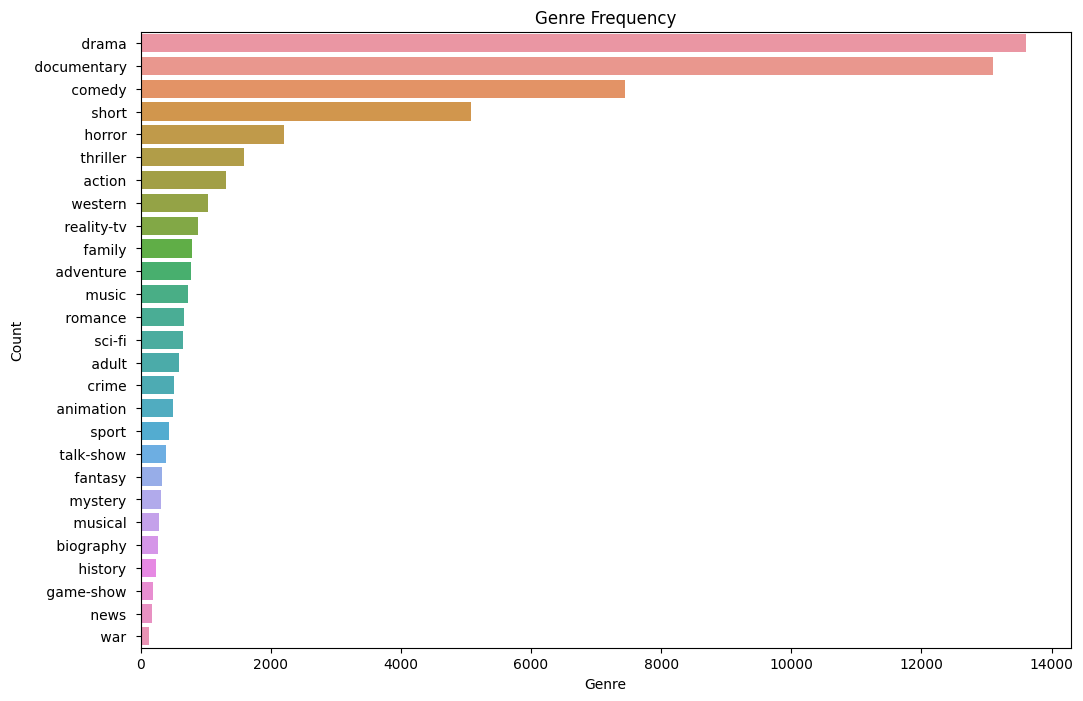

In [0]:
plt.figure(figsize=(12,8))
counts = train_data.Genre.value_counts()
sns.barplot(x=counts, y=counts.index, orient='h')  
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Frequency')

# Prepare Data

In [0]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
   
    text = text.lower()                                  # lower-case all characters
    text = re.sub('-',' ',text.lower())   # replace `word-word` as `word word`
    text = re.sub(f'[{string.digits}]',' ',text)  # remove digits
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # remove stopwords and stem other words
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text)                  # remove picture title
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text,language="english", preserve_line=True)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return re.sub(f'[{re.escape(string.punctuation)}]','',text) # remove punctuations


# Test your cleaning function
input_text = "Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38"
print(f'Original text: {input_text}')
print(f'Cleaned text: {clean_text(input_text)}')

Original text: Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38
Cleaned text: certain get dram boost hello bye iem


In [0]:
train_data['Cleaned_Description'] = train_data['Description'].apply(clean_text)
test_data['Cleaned_Description'] = test_data['Description'].apply(clean_text)
train_data.head()

,ID,Title,Genre,Description,Cleaned_Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,list convers doct parents year old osc learn n...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,broth sist past incestu rel cur murd relations...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empty stud field trip muse nat history lit...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemploy fath mak end meet edi twin sist ...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films titl ref recov body ground zero also sta...


# Sample Data

,frequency,percentage
sport,432,48.539326
musical,277,31.123596
news,181,20.337079


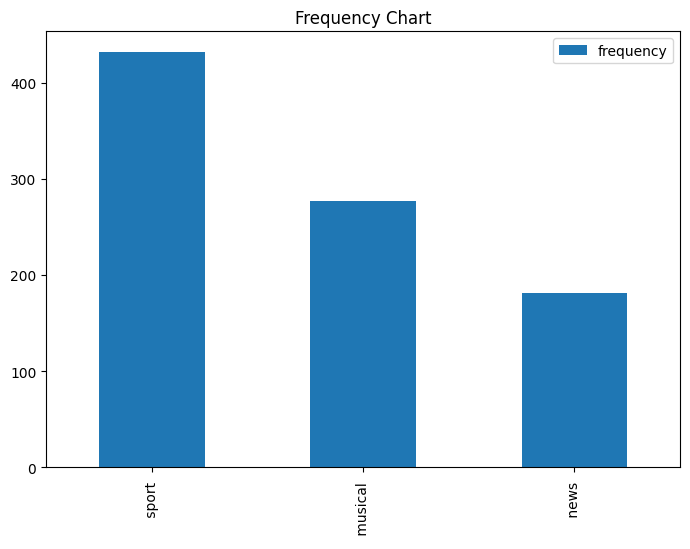

In [0]:
# subset sci-fi, comedy, drama
train_sub = train_data[train_data['Genre'].isin([' musical ', ' news ', ' sport '])]

def create_freq_table(df_col):
  ''' create a frequency table with counts and percentage '''
  frequency = pd.DataFrame(df_col.value_counts())
  frequency.columns = ['frequency']
  percentage = pd.DataFrame(df_col.value_counts(normalize=True) * 100)
  percentage.columns = ['percentage']
  resultDF = frequency.join(percentage)
  # resultDF['id'] = resultDF.reset_index().index + 1
  plt.rcParams["figure.figsize"] = [7, 5.6]
  plt.rcParams["figure.autolayout"] = True
  frequency.plot(kind='bar', title='Frequency Chart');
  return resultDF

create_freq_table(train_sub['Genre'])

,frequency,percentage
sport,431,48.536036
musical,276,31.081081
news,181,20.382883


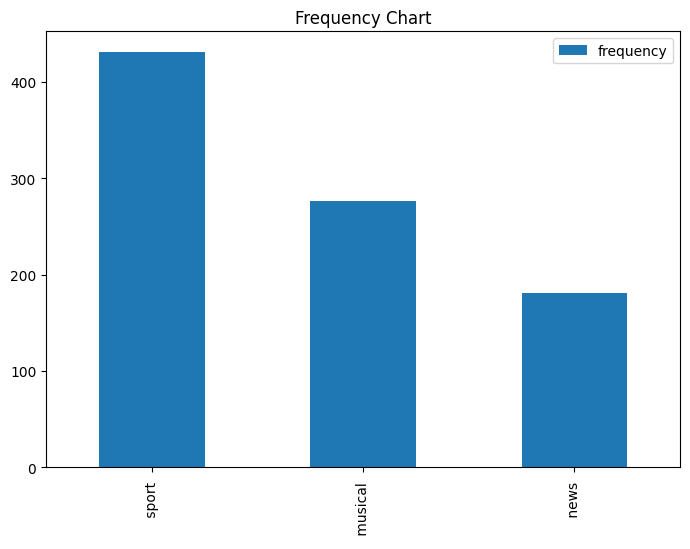

In [0]:
# subset sci-fi, comedy, drama
test_sub = test_data[test_data['Genre'].isin([' musical ', ' news ', ' sport '])]

def create_freq_table(df_col):
  ''' create a frequency table with counts and percentage '''
  frequency = pd.DataFrame(df_col.value_counts())
  frequency.columns = ['frequency']
  percentage = pd.DataFrame(df_col.value_counts(normalize=True) * 100)
  percentage.columns = ['percentage']
  resultDF = frequency.join(percentage)
  # resultDF['id'] = resultDF.reset_index().index + 1
  plt.rcParams["figure.figsize"] = [7, 5.6]
  plt.rcParams["figure.autolayout"] = True
  frequency.plot(kind='bar', title='Frequency Chart');
  return resultDF

create_freq_table(test_sub['Genre'])

In [0]:
le = preprocessing.LabelEncoder()
le.fit(train_sub['Genre'])
train_sub['Genre_num'] = le.transform(train_sub['Genre'])
test_sub['Genre_num'] = le.transform(test_sub['Genre'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Genre Labels")
print(le_name_mapping)

Genre Labels
{' musical ': 0, ' news ': 1, ' sport ': 2}


/root/.ipykernel/2541/command-1812440963741510-2359992538:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sub['Genre_num'] = le.transform(train_sub['Genre'])
/root/.ipykernel/2541/command-1812440963741510-2359992538:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sub['Genre_num'] = le.transform(test_sub['Genre'])


In [0]:
seed = 42
majority_class_1 = train_sub[train_sub['Genre_num'] == 2]
minority_class_1 = train_sub[train_sub['Genre_num'] == 0]
minority_class_2 = train_sub[train_sub['Genre_num'] == 1]

# Upsample the minority classes to match the majority classes
n_samples = len(majority_class_1)
minority_class_1_upsampled = resample(minority_class_1, replace=True, n_samples=n_samples, random_state=seed)
minority_class_2_upsampled = resample(minority_class_2, replace=True, n_samples=n_samples, random_state=seed)

# Combine the upsampled minority classes with the majority classes
balanced_data = pd.concat([majority_class_1, minority_class_1_upsampled, minority_class_2_upsampled])

# Shuffle the balanced train dataset
balanced_train_sub = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
print(" === Sample Size after Balance === ")
print(balanced_train_sub['Genre_num'].value_counts())
print()

# Create train dataset
X_train, y_train = balanced_train_sub['Cleaned_Description'], balanced_train_sub['Genre_num']
print(" === Train Sample Size === ")
print(y_train.value_counts())
print()

# Create test dataset
X_test, y_test = test_sub['Cleaned_Description'], test_sub['Genre_num']
print(" === Test Sample Size === ")
print(y_test.value_counts())

 === Sample Size after Balance === 
0    432
2    432
1    432
Name: Genre_num, dtype: int64

 === Train Sample Size === 
0    432
2    432
1    432
Name: Genre_num, dtype: int64

 === Test Sample Size === 
2    431
0    276
1    181
Name: Genre_num, dtype: int64


# TF-IDF

In [0]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train).toarray()
X_test_vec  = vectorizer.transform(X_test).toarray()
print(X_train_vec.shape)

with open('/dbfs/FileStore/tables/vectorizer.pkl', 'wb') as fin:
   pickle.dump(vectorizer, fin)

(1296, 1500)


# Neural Network

In [0]:
input_dim = X_train_vec.shape[1]  # Number of features

ngram_nn = Sequential()
ngram_nn.add(layers.Dense(512, input_dim = input_dim, activation='relu'))
ngram_nn.add(layers.Dense(256, activation = 'relu'))
ngram_nn.add(layers.Dense(128, activation = 'relu'))
ngram_nn.add(layers.Dense(4, activation = 'softmax'))  
ngram_nn.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['accuracy']
              )
n_epochs = 30
batch_size = 32

class_weights = dict(1 / train_sub['Genre_num'].value_counts(normalize=True))
history = ngram_nn.fit(X_train_vec, y_train, epochs = n_epochs, batch_size = batch_size, class_weight=class_weights, validation_split = 0.3) 

with open("/dbfs/FileStore/tables/ngram_nn.pkl", 'wb') as file:
  pickle.dump(ngram_nn, file)

clear_session()

loss, accuracy = ngram_nn.evaluate(X_train_vec, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = ngram_nn.evaluate(X_test_vec, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

print(" ============================== ")
train_predictions = ngram_nn.predict(X_train_vec)
y_train_pred = np.argmax(train_predictions, axis=1)

test_predictions = ngram_nn.predict(X_test_vec)
y_test_pred = np.argmax(test_predictions, axis=1)

print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(accuracy_score(y_train, y_train_pred))

print(confusion_matrix(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred, target_names=['comedy', 'drama', 'sci-fi']))
print(accuracy_score(y_test, y_test_pred))

Epoch 1/30
29/29 [==============================] - 3s 10ms/step - loss: 2.3384 - accuracy: 0.6527 - val_loss: 0.3715 - val_accuracy: 0.8355
Epoch 2/30
29/29 [==============================] - 0s 4ms/step - loss: 0.2299 - accuracy: 0.9735 - val_loss: 0.2035 - val_accuracy: 0.9332
Epoch 3/30
29/29 [==============================] - 0s 5ms/step - loss: 0.0136 - accuracy: 0.9989 - val_loss: 0.1496 - val_accuracy: 0.9512
Epoch 4/30
29/29 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1528 - val_accuracy: 0.9460
Epoch 5/30
29/29 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1562 - val_accuracy: 0.9434
Epoch 6/30
29/29 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1594 - val_accuracy: 0.9460
Epoch 7/30
29/29 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1625 - val_accuracy: 0.9434
Epoch 8/30
29/29 [=

## Confusion Matrix and ROC

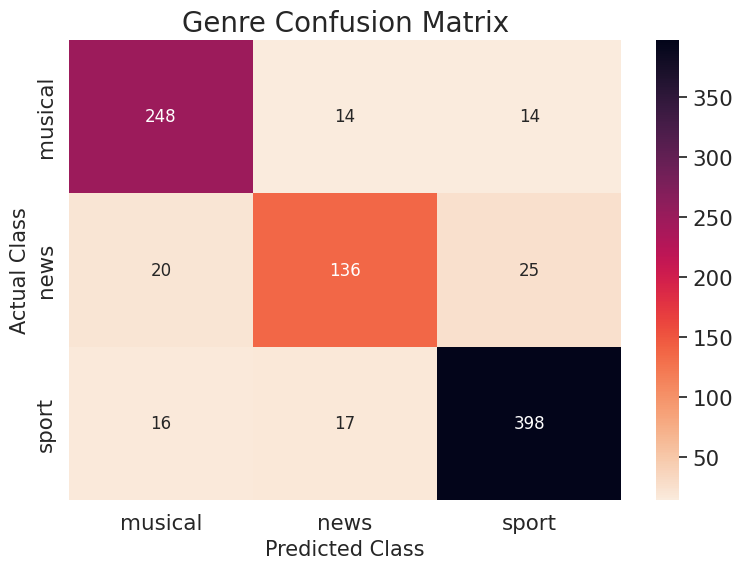

In [0]:
nn_data = {
  'musical': [248,20,16],
  'news':    [14,136,17],
  'sport':   [14,25,398]
}

nn_df = pd.DataFrame(nn_data)
nn_df.index = ['musical', 'news', 'sport']

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(nn_df, annot=True, annot_kws={"size": 12}, cmap='rocket_r', fmt='g')
plt.title('Genre Confusion Matrix', fontsize = 20) 
plt.xlabel('Predicted Class', fontsize = 15) 
plt.ylabel('Actual Class', fontsize = 15)
plt.show()

28/28 [==============================] - 0s 1ms/step


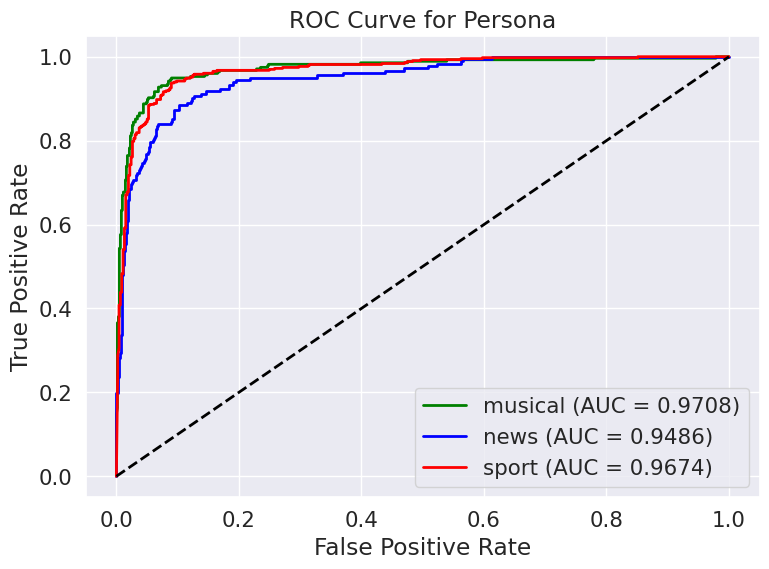

In [0]:
# with open("/dbfs/FileStore/tables/ngram_nn.pkl", 'rb') as file:
#   nn_model = pickle.load(file)

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_test_pred_score = ngram_nn.predict(X_test_vec)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
class_names = ['musical', 'news', 'sport']
colors = ['green', 'blue', 'red'] 
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='{} (AUC = {:.4f})'.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Persona')
plt.legend(loc='lower right')
plt.show()

# Sentence BERT Embedding

In [0]:
print(torch.cuda.mem_get_info())
clear_session()
torch.cuda.empty_cache()

(15738863616, 15843721216)


In [0]:
# Generate SBERT embeddings for train and test data
train_embeddings = sbert_model.encode(X_train.tolist(), batch_size = 1)
test_embeddings = sbert_model.encode(X_test.tolist(), batch_size = 1)
print(train_embeddings.shape[1])

768


# Neural Network

In [0]:
sbert_nn = Sequential()
sbert_nn.add(Dense(512, activation = 'relu', input_dim = train_embeddings.shape[1]))
sbert_nn.add(Dense(256, activation = 'relu'))
sbert_nn.add(Dense(128, activation = 'relu'))
sbert_nn.add(Dense(4, activation = 'softmax'))  
sbert_nn.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['accuracy']
              )
n_epochs = 30
batch_size = 32
class_weights = dict(1 / train_sub['Genre_num'].value_counts(normalize=True))
history = sbert_nn.fit(train_embeddings, y_train, epochs = n_epochs, batch_size = batch_size, class_weight=class_weights, validation_split = 0.3) 
with open("/dbfs/FileStore/tables/sbert_nn.pkl", 'wb') as file:
  pickle.dump(sbert_nn, file)

from keras.backend import clear_session
clear_session()

loss, accuracy = sbert_nn.evaluate(train_embeddings, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = sbert_nn.evaluate(test_embeddings, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

print(" ============================== ")
train_predictions = sbert_nn.predict(train_embeddings)
y_train_pred = np.argmax(train_predictions, axis=1)

test_predictions = sbert_nn.predict(test_embeddings)
y_test_pred = np.argmax(test_predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(accuracy_score(y_train, y_train_pred))

print(confusion_matrix(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred, target_names=['comedy', 'drama', 'sci-fi']))
print(accuracy_score(y_test, y_test_pred)) 

Epoch 1/30
29/29 [==============================] - 2s 10ms/step - loss: 2.0564 - accuracy: 0.7166 - val_loss: 0.2389 - val_accuracy: 0.9203
Epoch 2/30
29/29 [==============================] - 0s 4ms/step - loss: 0.5527 - accuracy: 0.9361 - val_loss: 0.1982 - val_accuracy: 0.9434
Epoch 3/30
29/29 [==============================] - 0s 4ms/step - loss: 0.3906 - accuracy: 0.9603 - val_loss: 0.1563 - val_accuracy: 0.9460
Epoch 4/30
29/29 [==============================] - 0s 4ms/step - loss: 0.1771 - accuracy: 0.9846 - val_loss: 0.2665 - val_accuracy: 0.9357
Epoch 5/30
29/29 [==============================] - 0s 4ms/step - loss: 0.0931 - accuracy: 0.9923 - val_loss: 0.2078 - val_accuracy: 0.9460
Epoch 6/30
29/29 [==============================] - 0s 4ms/step - loss: 0.0217 - accuracy: 0.9989 - val_loss: 0.2007 - val_accuracy: 0.9486
Epoch 7/30
29/29 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.1952 - val_accuracy: 0.9563
Epoch 8/30
29/29 [=

## Confusion Matrix and ROC

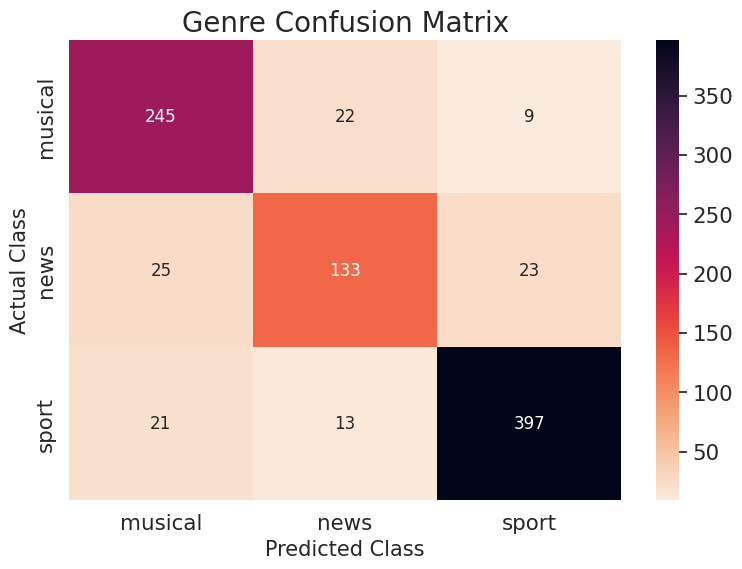

In [0]:
nn_data = {
  'musical': [245,25,21],
  'news':    [22,133,13],
  'sport':   [9,23,397]
}

nn_df = pd.DataFrame(nn_data)
nn_df.index = ['musical', 'news', 'sport']

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(nn_df, annot=True, annot_kws={"size": 12}, cmap='rocket_r', fmt='g')
plt.title('Genre Confusion Matrix', fontsize = 20) 
plt.xlabel('Predicted Class', fontsize = 15) 
plt.ylabel('Actual Class', fontsize = 15)
plt.show()

28/28 [==============================] - 0s 1ms/step


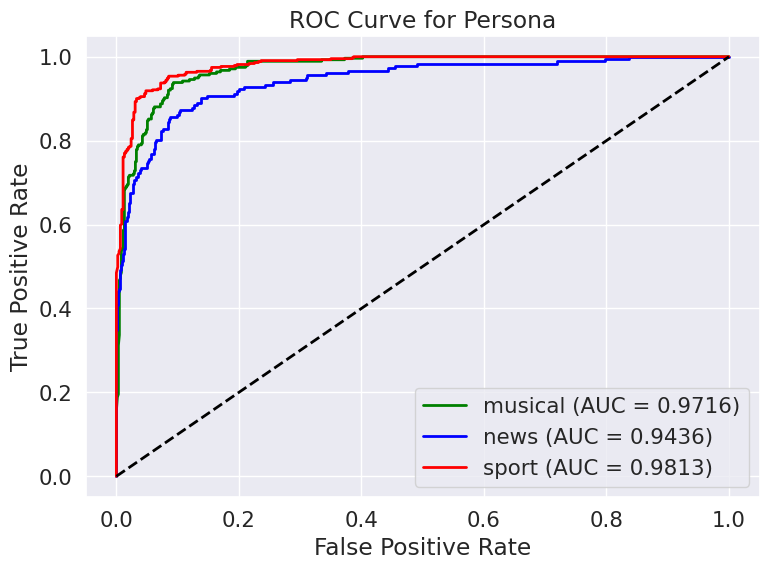

In [0]:
# with open("/dbfs/FileStore/tables/sbert_nn.pkl", 'rb') as file:
#   sbert_nn = pickle.load(file)

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_test_pred_score = sbert_nn.predict(test_embeddings)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
class_names = ['musical', 'news', 'sport']
colors = ['green', 'blue', 'red'] 
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='{} (AUC = {:.4f})'.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Persona')
plt.legend(loc='lower right')
plt.show()